In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import shap
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Starting enhanced model training with temporal features...")

Starting enhanced model training with temporal features...


In [15]:
df = pd.read_csv('../data/processed/player_features_v2_temporal.csv')

print(f"Dataset loaded")
print(f"Total records: {len(df)}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Dataset loaded
Total records: 750
Columns: 64

First few rows:
     player_name team   season position  age  games_played  minutes_per_game  \
0   Aaron Gordon  DEN  2021-22       PF   26            75         31.680000   
1   Aaron Gordon  DEN  2022-23       PF   27            68         30.220588   
2   Aaron Gordon  DEN  2023-24       PF   28            73         31.465753   
3  Aaron Holiday  PHO  2021-22       PG   25            22         16.272727   
4  Aaron Holiday  ATL  2022-23       PG   26            63         13.412698   

   points_per_game  rebounds_per_game  assists_per_game  ...  career_ppg_std  \
0        15.013333           5.853333          2.506667  ...        2.680807   
1        16.308824           6.558824          2.985294  ...        2.671845   
2        13.876712           6.452055          3.547945  ...        2.314659   
3         6.772727           2.500000          3.409091  ...        0.541473   
4         3.920635           1.174603          1.412698 

In [16]:
base_features = [
    'age', 'games_played', 'minutes_per_game',
    'points_per_game', 'rebounds_per_game', 'assists_per_game',
    'steals_per_game', 'blocks_per_game', 'turnovers_per_game',
    'field_goal_pct', 'free_throw_pct', 'true_shooting_pct',
    'points_per_minute', 'usage_rate', 'assist_rate', 'rebound_rate'
]

# Lag features from previous seasons (ALL 5 SEASONS)
lag_features = [
    # Points per game - all 5 lags
    'ppg_lag1', 'ppg_lag2', 'ppg_lag3', 'ppg_lag4', 'ppg_lag5',
    # Minutes per game - all 5 lags
    'mpg_lag1', 'mpg_lag2', 'mpg_lag3', 'mpg_lag4', 'mpg_lag5',
    # Rebounds per game
    'rpg_lag1', 'rpg_lag2', 'rpg_lag3',
    # Assists per game
    'apg_lag1', 'apg_lag2', 'apg_lag3',
    # Other key stats
    'spg_lag1', 'bpg_lag1',
    'games_lag1', 'games_lag2', 'games_lag3',
    'ts_pct_lag1', 'ts_pct_lag2', 'ts_pct_lag3',
    'fg_pct_lag1', 'fg_pct_lag2'
]

# Temporal trend features
trend_features = [
    'ppg_trend_2yr', 'ppg_trend_3yr', 'ppg_trend_4yr',
    'mpg_trend_2yr',
    'seasons_in_dataset', 'years_since_peak_ppg', 'peak_ppg',
    'career_ppg_avg', 'career_ppg_std',
    'career_games_avg', 'career_mpg_avg',
    'ppg_coefficient_variation'
]

# Combined feature set
feature_cols = base_features + lag_features + trend_features

# Target variables
target_cols = [
    'target_next_ppg',
    'target_next_rpg',
    'target_next_apg',
    'target_next_mpg',
    'target_next_ts_pct'
]

print(f"\nFeature categories:")
print(f"  Base features: {len(base_features)}")
print(f"  Lag features: {len(lag_features)}")
print(f"  Trend features: {len(trend_features)}")
print(f"  Total features: {len(feature_cols)}")
print(f"  Target variables: {len(target_cols)}")
print(f"\n✓ Feature count matches data preparation output (54 features)")


Feature categories:
  Base features: 16
  Lag features: 26
  Trend features: 12
  Total features: 54
  Target variables: 5

✓ Feature count matches data preparation output (54 features)


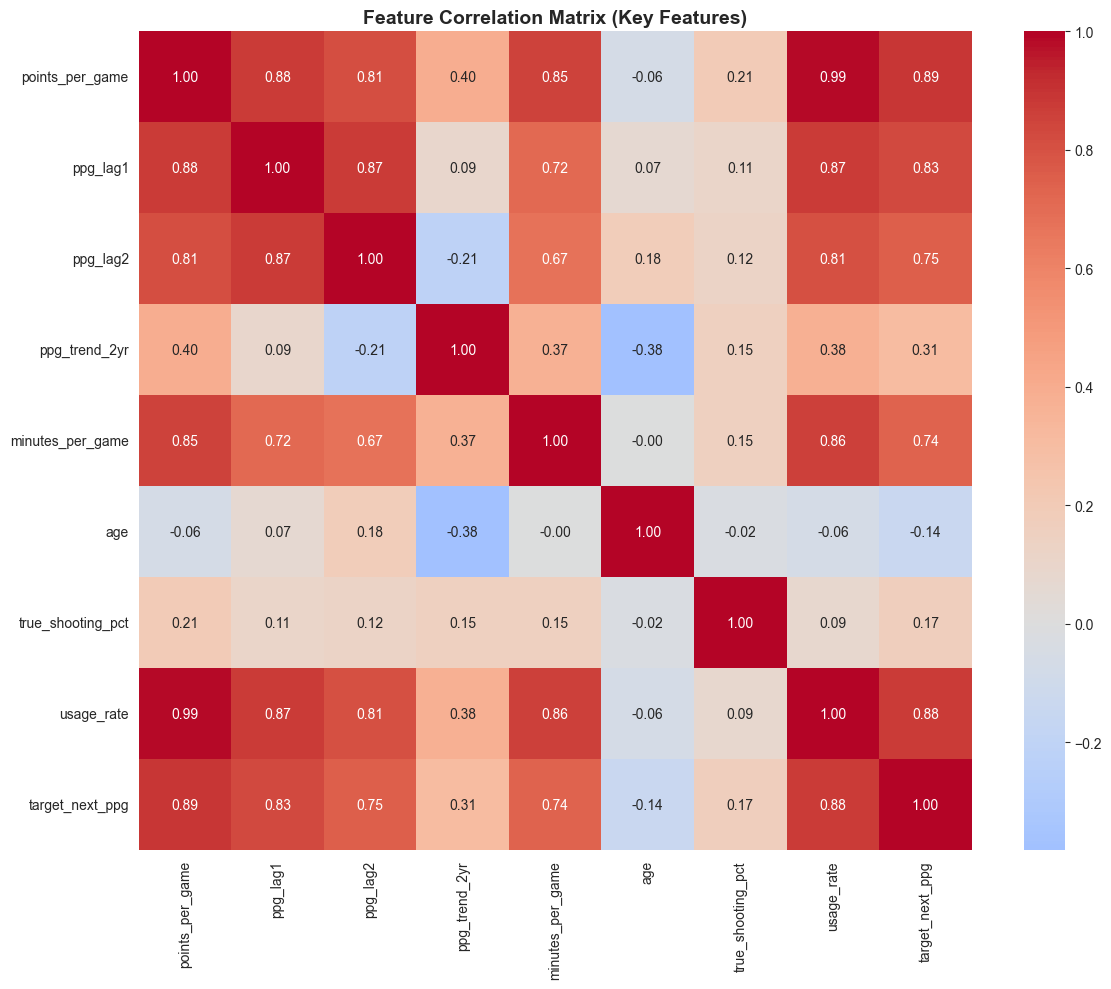


Key correlations with target (next season PPG):
target_next_ppg      1.000000
points_per_game      0.890475
usage_rate           0.877864
ppg_lag1             0.828015
ppg_lag2             0.753904
minutes_per_game     0.735874
ppg_trend_2yr        0.306810
true_shooting_pct    0.171050
age                 -0.143201
Name: target_next_ppg, dtype: float64


In [17]:
key_features = [
    'points_per_game', 'ppg_lag1', 'ppg_lag2', 
    'ppg_trend_2yr', 'minutes_per_game', 'age',
    'true_shooting_pct', 'usage_rate', 'target_next_ppg'
]

corr_matrix = df[key_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Key Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey correlations with target (next season PPG):")
target_corr = corr_matrix['target_next_ppg'].sort_values(ascending=False)
print(target_corr)

In [18]:
df_clean = df[feature_cols + target_cols].dropna()

X = df_clean[feature_cols]
y = df_clean[target_cols]

print(f"\nData preparation:")
print(f"  Records after cleaning: {len(df_clean)}")
print(f"  Features: {X.shape[1]}")
print(f"  Targets: {y.shape[1]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain-test split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")


Data preparation:
  Records after cleaning: 750
  Features: 54
  Targets: 5

Train-test split:
  Training samples: 600
  Test samples: 150


In [19]:
print("\nTraining multi-output XGBoost model...")

# Base XGBoost model with regularization
base_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

# Multi-output wrapper
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

print("Training complete")


Training multi-output XGBoost model...
Training complete


In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("=" * 70)
print("MODEL PERFORMANCE")
print("=" * 70)

results = []

for i, target in enumerate(target_cols):
    # Training metrics
    train_mae = mean_absolute_error(y_train.iloc[:, i], y_train_pred[:, i])
    train_r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
    
    # Test metrics
    test_mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
    test_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
    test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    
    print(f"\n{target}:")
    print(f"  Train MAE: {train_mae:.3f}  |  Test MAE: {test_mae:.3f}")
    print(f"  Train R2:  {train_r2:.3f}  |  Test R2:  {test_r2:.3f}")
    print(f"  Test RMSE: {test_rmse:.3f}")
    
    # Check overfitting
    mae_gap = test_mae - train_mae
    if mae_gap < 0.5:
        status = "Good fit"
    elif mae_gap > 1.0:
        status = "Possible overfitting"
    else:
        status = "Acceptable"
    
    print(f"  Gap: {mae_gap:.3f} ({status})")
    
    results.append({
        'target': target,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'mae_gap': mae_gap
    })

print("=" * 70)

MODEL PERFORMANCE

target_next_ppg:
  Train MAE: 0.940  |  Test MAE: 2.428
  Train R2:  0.965  |  Test R2:  0.826
  Test RMSE: 3.011
  Gap: 1.488 (Possible overfitting)

target_next_rpg:
  Train MAE: 0.335  |  Test MAE: 0.724
  Train R2:  0.966  |  Test R2:  0.817
  Test RMSE: 0.984
  Gap: 0.390 (Good fit)

target_next_apg:
  Train MAE: 0.296  |  Test MAE: 0.720
  Train R2:  0.965  |  Test R2:  0.791
  Test RMSE: 0.946
  Gap: 0.424 (Good fit)

target_next_mpg:
  Train MAE: 1.452  |  Test MAE: 3.672
  Train R2:  0.949  |  Test R2:  0.683
  Test RMSE: 4.901
  Gap: 2.220 (Possible overfitting)

target_next_ts_pct:
  Train MAE: 0.039  |  Test MAE: 0.040
  Train R2:  0.172  |  Test R2:  0.119
  Test RMSE: 0.057
  Gap: 0.001 (Good fit)


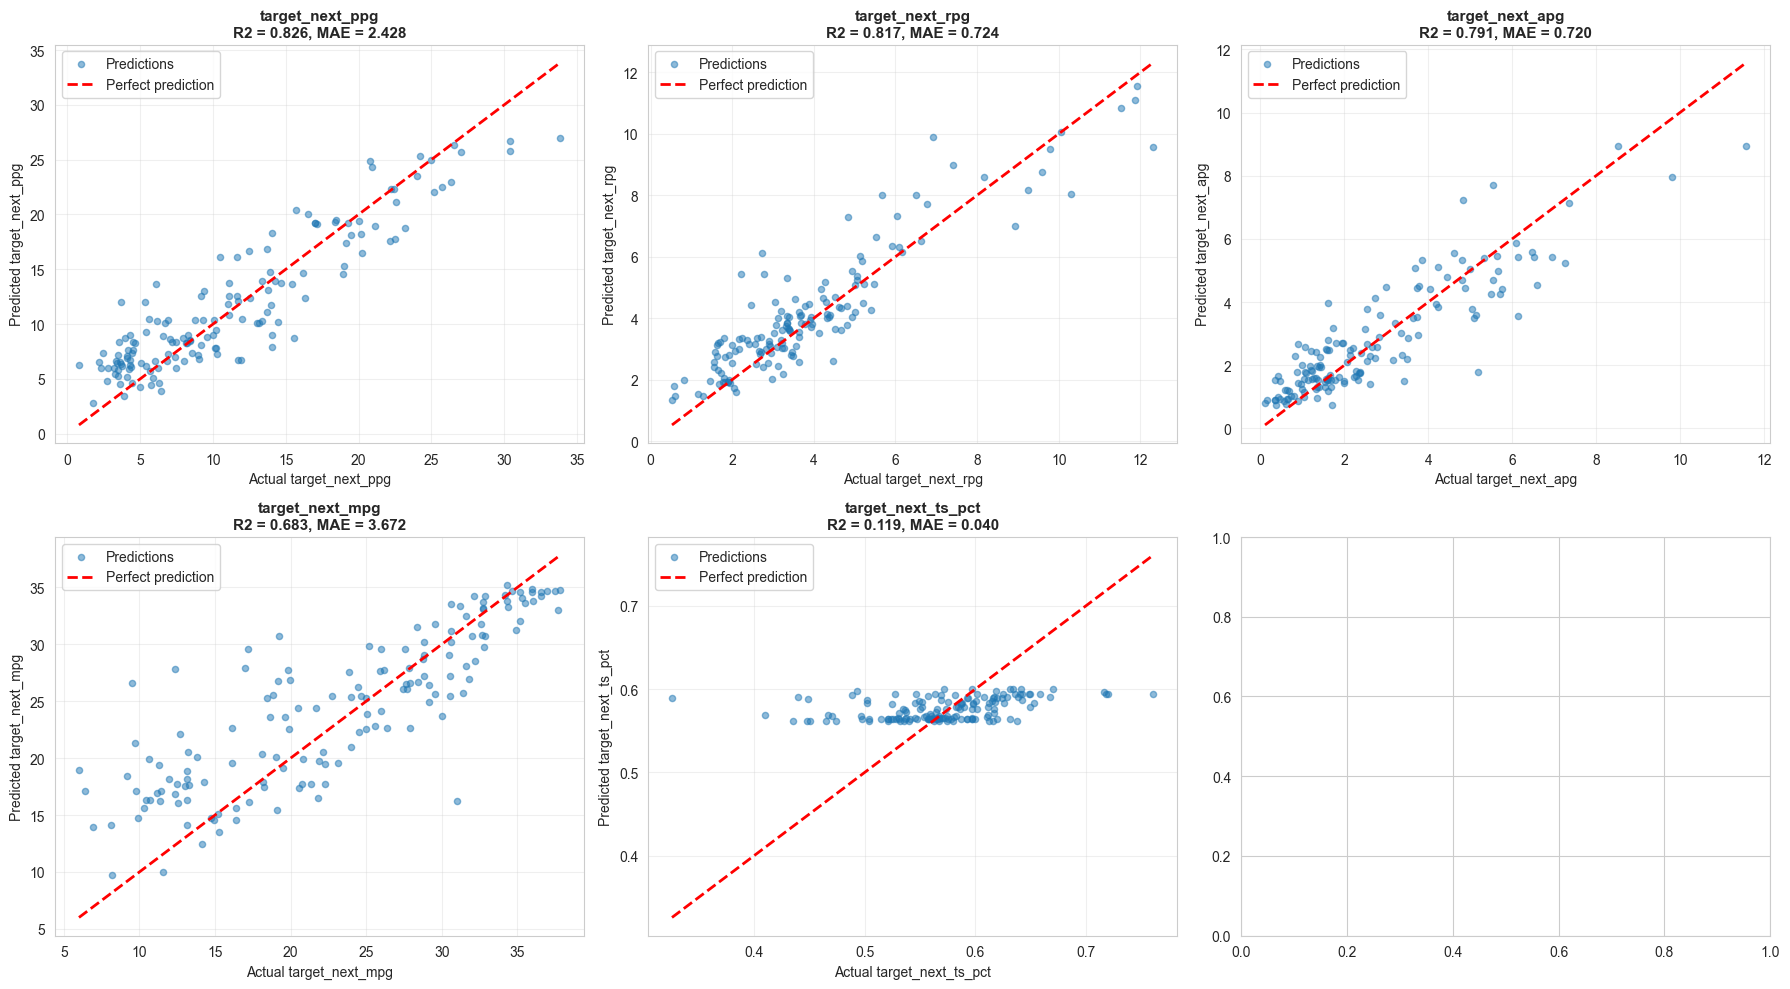

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, target in enumerate(target_cols):
    ax = axes[i]
    
    # Scatter plot
    ax.scatter(y_test.iloc[:, i], y_test_pred[:, i], 
               alpha=0.5, s=20, label='Predictions')
    
    # Perfect prediction line
    min_val = min(y_test.iloc[:, i].min(), y_test_pred[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_test_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'r--', lw=2, label='Perfect prediction')
    
    # Labels
    ax.set_xlabel(f'Actual {target}', fontsize=10)
    ax.set_ylabel(f'Predicted {target}', fontsize=10)
    ax.set_title(f'{target}\nR2 = {results[i]["test_r2"]:.3f}, MAE = {results[i]["test_mae"]:.3f}',
                 fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

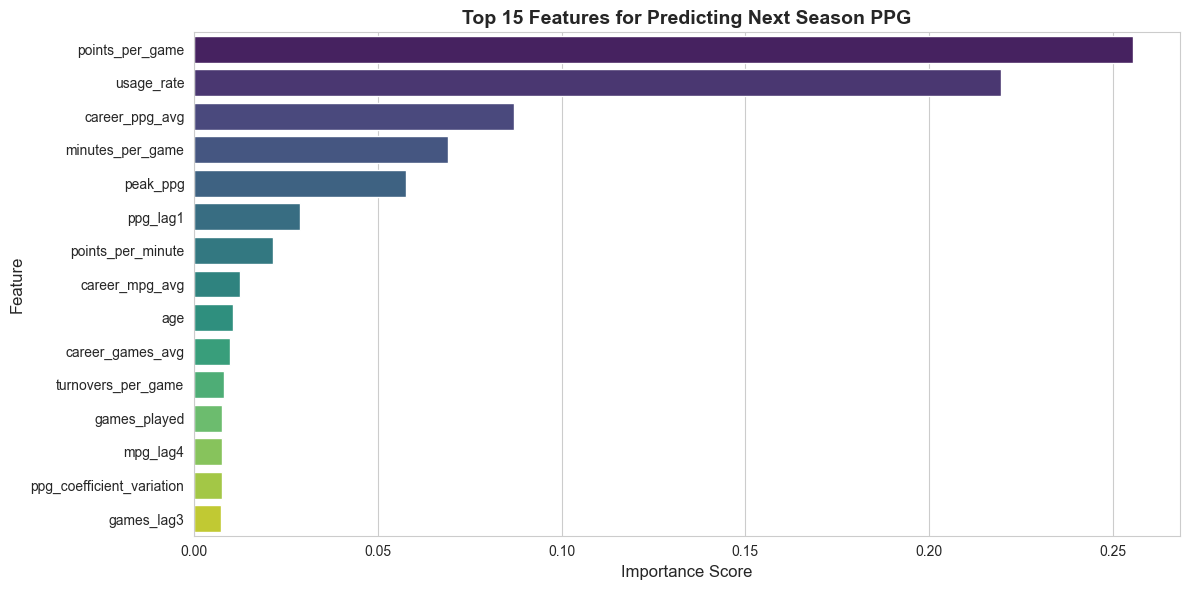


Top 10 most important features:
              feature  importance
3     points_per_game    0.255549
13         usage_rate    0.219707
49     career_ppg_avg    0.087121
2    minutes_per_game    0.068989
48           peak_ppg    0.057777
16           ppg_lag1    0.028778
12  points_per_minute    0.021506
52     career_mpg_avg    0.012590
0                 age    0.010636
51   career_games_avg    0.009723


In [22]:
ppg_estimator = model.estimators_[0]
importance = ppg_estimator.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features for Predicting Next Season PPG', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10))


Generating SHAP explanations...


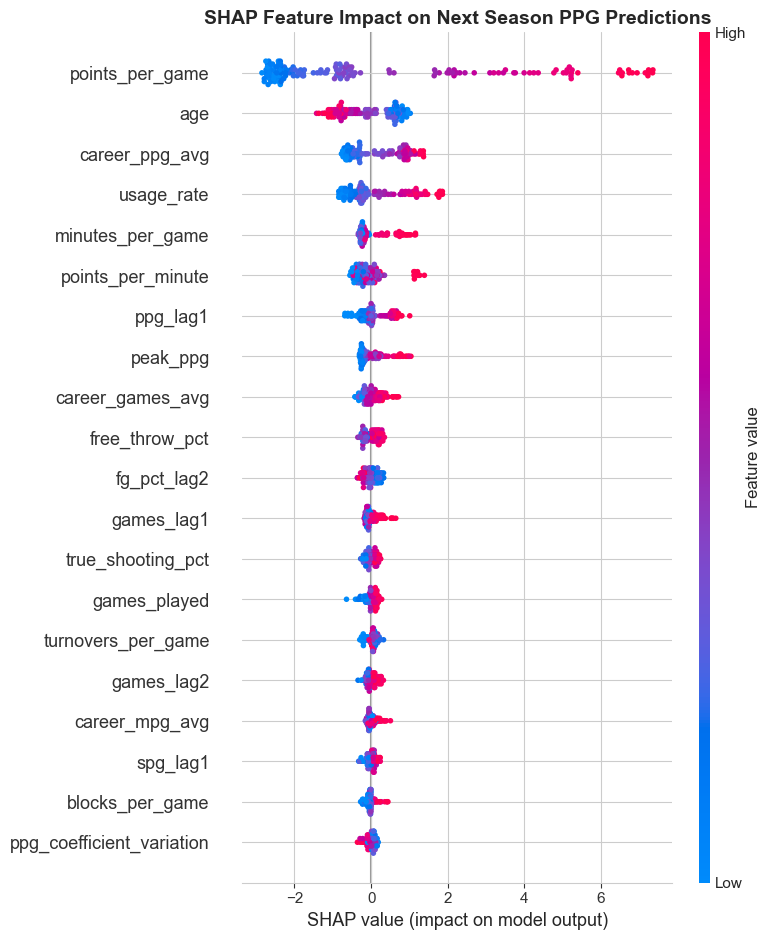

SHAP analysis complete


In [23]:
print("\nGenerating SHAP explanations...")

# Create explainer for first target (PPG)
ppg_estimator = model.estimators_[0]
explainer = shap.TreeExplainer(ppg_estimator)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title('SHAP Feature Impact on Next Season PPG Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("SHAP analysis complete")

In [24]:
print("\nPerforming cross-validation on PPG prediction...")

# Create single-output model for PPG only (for cross-validation)
cv_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

# Cross-validation on PPG target only
cv_scores = cross_val_score(
    cv_model, X, y['target_next_ppg'],
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

cv_mae_scores = -cv_scores

print("\nCross-Validation Results (5-Fold):")
print(f"  Mean MAE: {cv_mae_scores.mean():.3f}")
print(f"  Std MAE:  {cv_mae_scores.std():.3f}")
print(f"  Min MAE:  {cv_mae_scores.min():.3f}")
print(f"  Max MAE:  {cv_mae_scores.max():.3f}")


Performing cross-validation on PPG prediction...

Cross-Validation Results (5-Fold):
  Mean MAE: 2.390
  Std MAE:  0.148
  Min MAE:  2.202
  Max MAE:  2.621


In [25]:
print("\nSample predictions on test set:")
print("=" * 100)

sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    actual = y_test.iloc[idx]
    predicted = y_test_pred[idx]
    
    print(f"\nSample {idx + 1}:")
    print(f"  Actual next PPG:    {actual['target_next_ppg']:.2f}  |  Predicted: {predicted[0]:.2f}")
    print(f"  Actual next RPG:    {actual['target_next_rpg']:.2f}  |  Predicted: {predicted[1]:.2f}")
    print(f"  Actual next APG:    {actual['target_next_apg']:.2f}  |  Predicted: {predicted[2]:.2f}")
    print(f"  Features: Age={X_test.iloc[idx]['age']:.0f}, PPG={X_test.iloc[idx]['points_per_game']:.1f}, PPG_lag1={X_test.iloc[idx]['ppg_lag1']:.1f}")

print("=" * 100)


Sample predictions on test set:

Sample 20:
  Actual next PPG:    4.44  |  Predicted: 7.35
  Actual next RPG:    4.18  |  Predicted: 4.94
  Actual next APG:    0.72  |  Predicted: 1.03
  Features: Age=24, PPG=7.2, PPG_lag1=10.6

Sample 138:
  Actual next PPG:    14.25  |  Predicted: 13.94
  Actual next RPG:    9.79  |  Predicted: 9.52
  Actual next APG:    1.66  |  Predicted: 1.70
  Features: Age=23, PPG=16.1, PPG_lag1=13.2

Sample 34:
  Actual next PPG:    5.38  |  Predicted: 6.16
  Actual next RPG:    1.81  |  Predicted: 1.93
  Actual next APG:    0.62  |  Predicted: 0.94
  Features: Age=37, PPG=6.5, PPG_lag1=7.8

Sample 72:
  Actual next PPG:    11.73  |  Predicted: 12.14
  Actual next RPG:    3.93  |  Predicted: 3.70
  Actual next APG:    3.73  |  Predicted: 3.51
  Features: Age=24, PPG=9.3, PPG_lag1=19.2

Sample 6:
  Actual next PPG:    6.73  |  Predicted: 10.10
  Actual next RPG:    2.17  |  Predicted: 2.99
  Actual next APG:    1.05  |  Predicted: 1.57
  Features: Age=24, PPG=1

In [26]:
print("\nSaving model and artifacts...")

# Save multi-output model
with open('../models/player_multioutput_v2.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save SHAP explainer
with open('../models/shap_explainer_v2.pkl', 'wb') as f:
    pickle.dump(explainer, f)

# Save feature names
with open('../models/feature_names_v2.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

# Save target names
with open('../models/target_names_v2.txt', 'w') as f:
    f.write('\n'.join(target_cols))

# Save metadata
metadata = {
    'model_version': 'v2',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_cols),
    'n_targets': len(target_cols),
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test),
    'feature_categories': {
        'base': len(base_features),
        'lag': len(lag_features),
        'trend': len(trend_features)
    },
    'performance': {
        target: {
            'test_mae': float(results[i]['test_mae']),
            'test_rmse': float(results[i]['test_rmse']),
            'test_r2': float(results[i]['test_r2'])
        }
        for i, target in enumerate(target_cols)
    },
    'cv_ppg_mean_mae': float(cv_mae_scores.mean()),
    'cv_ppg_std_mae': float(cv_mae_scores.std())
}

with open('../models/model_metadata_v2.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nModel artifacts saved:")
print("  - player_multioutput_v2.pkl")
print("  - shap_explainer_v2.pkl")
print("  - feature_names_v2.txt")
print("  - target_names_v2.txt")
print("  - model_metadata_v2.json")
print("\nTraining complete")


Saving model and artifacts...

Model artifacts saved:
  - player_multioutput_v2.pkl
  - shap_explainer_v2.pkl
  - feature_names_v2.txt
  - target_names_v2.txt
  - model_metadata_v2.json

Training complete
